# Chest Scanner Model
## created by johann

## setup

In [1]:
!pip install tensorflow matplotlib numpy

You should consider upgrading via the 'C:\Users\J\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(device_lib.list_local_devices())

Num GPUs Available:  0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13939571593747359251
xla_global_id: -1
]


We will be using VGG
https://arxiv.org/pdf/1409.1556v6.pdf

## 1. Data

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

In [4]:
data_dir = 'Data/'

In [5]:
img_height = 224
img_width = 224
batch_size = 256

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir+'train',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 613 files belonging to 4 classes.
Using 491 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir+'valid',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 72 files belonging to 4 classes.
Using 14 files for validation.


In [8]:
class_names = train_ds.class_names
print('Train Dataset Classes')
print(class_names)

Train Dataset Classes
['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']


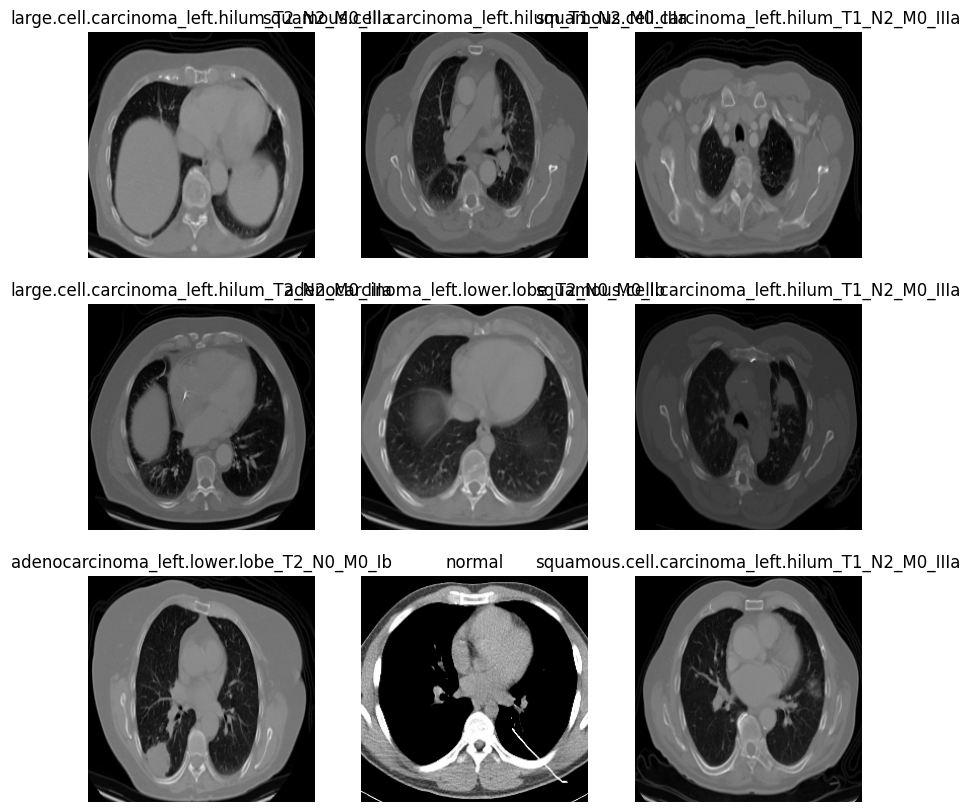

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(256, 224, 224, 3)
(256,)


## 2. Image Augmentation

In [11]:
from tensorflow.keras import layers

In [12]:
data_augmentation = tf.keras.Sequential([
    # Brightness
    layers.RandomBrightness(0.5),
    # Contrast
    layers.RandomContrast(0.5),
    # Flip
    layers.RandomFlip("horizontal_and_vertical"),
    # Rotation
    layers.RandomRotation(0.2),
    # Crop
    layers.RandomCrop(0.2, 0.2),

])

## 3. CNN Model Creation

In [13]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## 4. Training

In [15]:
epochs=25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
2/2 [==============================] - 9s 5s/step - loss: 1.4388 - accuracy: 0.3055 - val_loss: 1.3228 - val_accuracy: 0.2857
Epoch 2/25
2/2 [==============================] - 15s 3s/step - loss: 1.2413 - accuracy: 0.4236 - val_loss: 1.1405 - val_accuracy: 0.6429
Epoch 3/25
2/2 [==============================] - 6s 3s/step - loss: 1.1123 - accuracy: 0.5132 - val_loss: 1.0073 - val_accuracy: 0.5714
Epoch 4/25
2/2 [==============================] - 6s 3s/step - loss: 0.9887 - accuracy: 0.5295 - val_loss: 0.9286 - val_accuracy: 0.5714
Epoch 5/25
2/2 [==============================] - 6s 3s/step - loss: 0.8726 - accuracy: 0.6151 - val_loss: 0.7742 - val_accuracy: 0.5714
Epoch 6/25
2/2 [==============================] - 6s 3s/step - loss: 0.7316 - accuracy: 0.7536 - val_loss: 0.7167 - val_accuracy: 0.7143
Epoch 7/25
2/2 [==============================] - 7s 3s/step - loss: 0.6364 - accuracy: 0.7475 - val_loss: 0.7502 - val_accuracy: 0.6429
Epoch 8/25
2/2 [========================

## 5. Testing

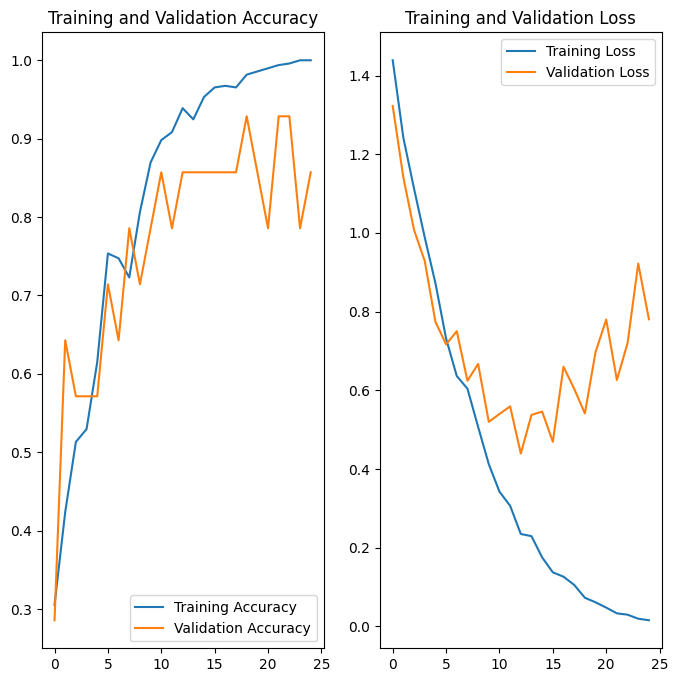

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 6. Exporting

In [17]:
model.save("model.h5")